# Block CA imputation strategy
This notebook contains the development code for the block CA imputation strategy.

In [1]:
%reload_ext autoreload
%autoreload 2
%reload_ext rpy2.ipython

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.io as sio
import scipy.sparse as sps
from scipy.sparse.linalg import svds
from scipy.linalg import svdvals

from ampute import ampute_mcar, ampute_mar
from coclust_mod_impute import (CoclustModImpute,
                                summarize_blocks, get_block_counts,
                                _impute_block_representative)
from utils import show_matrix
import joblib
import os # to play sound at the end of the execution

In [3]:
np.set_printoptions(precision=3)

In [4]:
X = np.array([
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1],
    [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0],
    [1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0]])
X = X[np.ix_([0, 2, 7, 1, 4, 8, 3, 5, 6],
             [ 0,  4,  5, 15,  8,  9, 12, 13,  7, 10,  1,  2,  3,  6, 11, 14])]

n_clusters = 3
w = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2])
z = np.array([0, 0, 0, 1, 1, 1, 2, 2, 2])

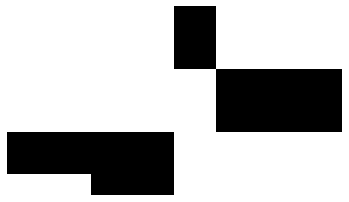

In [5]:
show_matrix(X)

In [6]:
res, r_nan, c_nan = ampute_mcar(X, .1)
print(np.isnan(res).sum())
print(res)

14
[[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0. nan  0.  0.  0.]
 [ 0.  0. nan nan  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. nan  0.  0.  0.  0. nan  0.  1.  1.  1.  1.  1.  1.]
 [ 0. nan nan  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1. nan  1.]
 [ 0.  0. nan  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1. nan  1.]
 [ 1. nan  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1. nan  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. nan nan  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]


## Implementation of CA approximation of a matrix

In [7]:
def shrink_ca(X, ncp=2):
    n, p = X.shape
    N = X.sum()
    P = X / N
    Rc = P.sum(axis=0)[np.newaxis, :]
    Rr = P.sum(axis=1)[:, np.newaxis]
    
    S = (P - Rr @ Rc) / Rr**.5 / Rc**.5
    u, s, v = np.linalg.svd(S, full_matrices=True)

    sigma2 = (s[ncp:]**2).sum() / ((n-1)*(p-1) - (n-1)*ncp - (p-1)*ncp + ncp**2)
    lambda_shrunk = (s[:ncp]**2 - n * p / min(p,n-1) * sigma2) / s[:ncp]
    
    if ncp == 1:
        recon = (u[:,0] * lambda_shrunk)[:,np.newaxis] @ v[0,:][np.newaxis,:]
    else:
        recon = (u[:,:ncp] * lambda_shrunk) @ v[:ncp,]
    
    recon = N * (((recon * Rr**.5) * Rc**.5) + Rr @ Rc)
    return recon

rec = shrink_ca(X, ncp=3)
np.allclose(X, rec)
np.sum((X - rec)**2)

True

4.934560527463752e-30

## Modification to use sparse SVD

In [8]:
def shrink_ca2(X, ncp=2):
    n, p = X.shape
    N = X.sum()
    N = 1 if N == 0 else N
    P = X / N
    Rc = P.sum(axis=0)[np.newaxis, :]
    Rr = P.sum(axis=1)[:, np.newaxis]
    Rc[Rc==0] = 1
    Rr[Rr==0] = 1
    S = (P - Rr @ Rc) / Rr**.5 / Rc**.5
    
#     print(X)
#     print(S)

    svals = svdvals(S)
    u, s, v = sps.linalg.svds(S, k=ncp)
#     print(s)
#     print(svals)
    zero_vals = np.isclose(0, s) # find which singular values are null
    den = ((n-1)*(p-1) - (n-1)*ncp - (p-1)*ncp + ncp**2)
    sigma2 = (svals[ncp:]**2).sum() / (1 if den == 0 else den)
#     print('sigma2', sigma2)
    lambda_shrunk = s.copy()
#     print(s[~zero_vals])
#     print(lambda_shrunk)
    lambda_shrunk[~zero_vals] = (s[~zero_vals]**2 - n * p / min(p,n-1) * sigma2) / s[~zero_vals]
#     print(lambda_shrunk)
    
    recon = (u * lambda_shrunk) @ v
    recon = N * (((recon * Rr**.5) * Rc**.5) + Rr @ Rc)
    recon[recon < 0] = 0 # account for numerical errors and avoid negative values
    
    return recon

rec = shrink_ca2(X, ncp=3)
# print(rec)
print(rec.shape)
np.allclose(X, rec)
np.sum((X - rec)**2)

(9, 16)


True

4.856376799518244e-30

## Block CA imputation implementation

In [9]:
def impute_block_ca2(X, Z, W, z, w, r_nan, c_nan, ncp=2):
    z = z.ravel()
    w = w.ravel()
    zvals = np.unique(z)
    wvals = np.unique(w)
    
    for zval in zvals:
        for wval in wvals:
            block_z = z==zval
            block_w = w==wval
                           
            pois = (z[r_nan] == zval) & (w[c_nan] == wval)
            
            X_2_B_r = np.ones(z.shape[0], dtype=int)*-1
            X_2_B_c = np.ones(w.shape[0], dtype=int)*-1

            if np.any(pois):
#                 print(f'block {zval,wval} has nans')
                block = X[np.ix_(block_z,block_w)]
                min_dim = min(block.shape)
                if min_dim < 2:
                    summary = block.sum() / block.size
                    X[r_nan[pois], c_nan[pois]] = summary
                else:
                    recon = shrink_ca2(block, min(ncp, min_dim-1))

                    X_2_B_r[block_z] = np.arange(block.shape[0])
                    X_2_B_c[block_w] = np.arange(block.shape[1])

                    X[r_nan[pois], c_nan[pois]] = recon[X_2_B_r[r_nan[pois]], X_2_B_c[c_nan[pois]]]

    return X

X_missing, r_nan, c_nan = ampute_mcar(X, .2)

# print(r_nan)
# print(c_nan)
# print(X_missing[r_nan, c_nan])
print('amputed data')
print(X_missing.T)
# res = impute_block_ca2(X.astype(float), None, None, z, w, r_nan, c_nan)
# print(np.round(res.T, 2))
model2 = (CoclustModImpute(n_clusters=n_clusters, n_init=10)
          .fit(X_missing, impute_block_ca2, initial_vals=None, ))
impute2 = model2.X_
print('imputed data')
print(np.round(impute2.T,2))
print('original data')
print(X.T)

amputed data
[[ 0.  0.  0.  0. nan  0.  1.  1.  0.]
 [ 0.  0.  0.  0. nan  0. nan nan  0.]
 [ 0. nan  0.  0. nan nan  1.  1.  0.]
 [ 0. nan  0. nan  0.  0.  1.  1.  0.]
 [nan  0.  0.  0.  0.  0. nan  1. nan]
 [ 0.  0.  0.  0. nan  0.  1. nan nan]
 [ 0.  0.  0.  0.  0.  0.  1.  1.  1.]
 [ 0.  0.  0. nan  0.  0.  1. nan  1.]
 [ 1.  1.  1. nan  0.  0.  0.  0.  0.]
 [nan  1.  1.  0. nan  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  1.  1.  0.  0.  0.]
 [nan nan  0.  1.  1.  1.  0.  0.  0.]
 [nan  0.  0.  1.  1.  1.  0.  0.  0.]
 [ 0.  0. nan  1.  1.  1.  0. nan  0.]
 [ 0.  0.  0.  1. nan nan nan  0.  0.]
 [ 0.  0.  0.  1.  1.  1.  0.  0.  0.]]
imputed data
[[0.   0.   0.   0.   0.   0.   1.   1.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   1.   1.   0.  ]
 [0.   0.   0.   0.   0.   0.   1.   1.   0.  ]
 [0.   0.   0.   0.   0.   0.   1.   1.   0.01]
 [0.   0.   0.   0.   0.   0.   1.   1.   0.01]
 [0.   0.   0.   0.   0.   0.   1.   1.   1.  ]
 [0.   0.   0

In [10]:
diff = np.abs(X-model2.X_)
print(f"RMSE: {((diff**2).sum()/r_nan.shape[0])**.5}")

RMSE: 0.37551085049331023
